# Laydown Planner - Optimization
Optimizes object placement using 2D bin packing with category-based nesting and stacking.

## 1. Setup and Imports

In [58]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
import ezdxf
import os

print('All imports successful!')

All imports successful!


## 2. Load Data

In [59]:
objects_df = pd.read_csv('../data/sample_objects.csv')

print(f'Loaded {len(objects_df)} object types')
print(f'\nCategories:')
print(objects_df['category'].value_counts())
print(f'\nStackable objects:')
print(objects_df[objects_df['stackable'] == True][['name', 'stackable', 'max_stack_height']])

Loaded 50 object types

Categories:
category
Category 1    19
Category 2    16
Category 3    15
Name: count, dtype: int64

Stackable objects:
         name  stackable  max_stack_height
0    Object A       True                10
1    Object B       True                 8
3    Object D       True                12
5    Object F       True                15
6    Object G       True                 9
8    Object I       True                11
10   Object K       True                13
11   Object L       True                 6
12   Object M       True                 8
14   Object O       True                10
15   Object P       True                 9
17   Object R       True                 8
19   Object T       True                 5
20   Object U       True                15
22   Object W       True                14
23   Object X       True                13
25   Object Z       True                12
26  Object AA       True                11
27  Object AB       True                1

### 2.5 Segregate by Category

In [62]:
# Category Segregation Rules
print("=== CATEGORY SEGREGATION CONFIGURATION ===\n")

categories = objects_df['category'].unique()
print(f"Available categories: {list(categories)}")

# Create default compatibility matrix (all compatible by default)
compatibility_matrix = {}
for cat1 in categories:
    compatibility_matrix[cat1] = {}
    for cat2 in categories:
        compatibility_matrix[cat1][cat2] = True  # True = can be together

print("\nDefault: All categories can share bins")
print("\nEnter segregation rules (separate with comma):")
print("Format: 'Category1,Category2' means they CANNOT share a bin")
print("Example: 'Steel,Wood,Concrete' means Steel-Wood and Steel-Concrete cannot mix")
print("(Type 'none' or just press Enter to skip)")

rule_input = input("\nSegregation rules: ").strip()

if rule_input.lower() != 'none' and rule_input:
    rules = [r.strip() for r in rule_input.split(',')]
    print(f"\nApplying rules: {rules}")
    
    # Mark incompatible pairs
    for i in range(len(rules)):
        for j in range(i + 1, len(rules)):
            cat1, cat2 = rules[i], rules[j]
            if cat1 in compatibility_matrix and cat2 in compatibility_matrix:
                compatibility_matrix[cat1][cat2] = False
                compatibility_matrix[cat2][cat1] = False
                print(f"  ✗ {cat1} cannot share bins with {cat2}")

# Display compatibility matrix
print("\n=== COMPATIBILITY MATRIX ===")
print(f"\n{'Category':<15}", end='')
for cat in categories:
    print(f"{cat:<15}", end='')
print()
print("-" * (15 + len(categories) * 15))

for cat1 in categories:
    print(f"{cat1:<15}", end='')
    for cat2 in categories:
        compatible = compatibility_matrix[cat1][cat2]
        symbol = "✓" if compatible else "✗"
        print(f"{symbol:<15}", end='')
    print()

print("\n✓ Segregation rules configured")

=== CATEGORY SEGREGATION CONFIGURATION ===

Available categories: ['Category 1', 'Category 2', 'Category 3']

Default: All categories can share bins

Enter segregation rules (separate with comma):
Format: 'Category1,Category2' means they CANNOT share a bin
Example: 'Steel,Wood,Concrete' means Steel-Wood and Steel-Concrete cannot mix
(Type 'none' or just press Enter to skip)

Applying rules: ['Category 1', 'Category 2']
  ✗ Category 1 cannot share bins with Category 2

=== COMPATIBILITY MATRIX ===

Category       Category 1     Category 2     Category 3     
------------------------------------------------------------
Category 1     ✓              ✗              ✓              
Category 2     ✗              ✓              ✓              
Category 3     ✓              ✓              ✓              

✓ Segregation rules configured


## 3. Define 2D Bin Packing Classes

In [63]:
class Bin:
    def __init__(self, width, length, bin_id, min_spacing=0, compatibility_matrix=None):
        self.width = width
        self.length = length
        self.bin_id = bin_id
        self.rectangles = []
        self.min_spacing = min_spacing
        self.compatibility_matrix = compatibility_matrix or {}
    
    def can_fit(self, rect):
        for existing in self.rectangles:
            if self._overlaps(rect, existing):
                return False
        
        # Check compatibility
        if self.compatibility_matrix:
            for existing in self.rectangles:
                if not self.compatibility_matrix.get(rect.category, {}).get(existing.category, True):
                    return False
        
        # Check if rect fits in bin with spacing
        if rect.x + rect.get_width() + self.min_spacing > self.width:
            return False
        if rect.y + rect.get_length() + self.min_spacing > self.length:
            return False
        
        return True
    
    def can_accept_category(self, category):
        """Check if this bin can accept a new category."""
        if not self.rectangles:
            return True
        
        if not self.compatibility_matrix:
            return True
        
        # Check compatibility with all existing categories in bin
        existing_categories = set(rect.category for rect in self.rectangles)
        
        for existing_cat in existing_categories:
            if not self.compatibility_matrix.get(category, {}).get(existing_cat, True):
                return False
        
        return True
    
    def _overlaps(self, rect1, rect2):
        return not (rect1.x + rect1.get_width() + self.min_spacing <= rect2.x or 
                   rect1.x >= rect2.x + rect2.get_width() + self.min_spacing or
                   rect1.y + rect1.get_length() + self.min_spacing <= rect2.y or 
                   rect1.y >= rect2.y + rect2.get_length() + self.min_spacing)

print('✓ Bin class updated with segregation support')

✓ Bin class updated with segregation support


## 4. Implement Packing Algorithm

In [64]:
def pack_objects(objects_df, bin_width=100, bin_length=100, min_spacing=0, compatibility_matrix=None):
    """
    Pack objects by category into bins using 2D bin packing with segregation rules.
    """
    categories = objects_df['category'].unique()
    all_bins = []
    
    for category in categories:
        category_df = objects_df[objects_df['category'] == category]
        print(f"\nProcessing category: {category} ({len(category_df)} objects)")
        
        # Create rectangles for this category
        rects = []
        for _, row in category_df.iterrows():
            rect = Rectangle(
                width=float(row['width']),
                length=float(row['length']),
                obj_id=row['object_id'],
                obj_name=row['name'],
                category=row['category'],
                weight=float(row['weight']),
                stackable=row['stackable'] in [True, 'True', 'TRUE'],
                max_stack=int(row['max_stack_height'])
            )
            rects.append(rect)
        
        # Sort by area (largest first)
        rects.sort(key=lambda r: r.area(), reverse=True)
        
        # Pack into bins
        bins = []
        
        for rect in rects:
            placed = False
            
            # Try to stack on existing object of same type
            if rect.stackable:
                for bin_obj in bins:
                    for existing in bin_obj.rectangles:
                        if (existing.obj_id == rect.obj_id and 
                            existing.stack_height < existing.max_stack):
                            # Stack on top
                            rect.x = existing.x
                            rect.y = existing.y
                            rect.stack_height = existing.stack_height + 1
                            existing.stack_height = rect.stack_height
                            bin_obj.rectangles.append(rect)
                            placed = True
                            print(f"    Stacked: {rect.obj_name} (stack height: {rect.stack_height})")
                            break
                    if placed:
                        break
            
            # If not stacked, try to fit in existing bin (respecting segregation)
            if not placed:
                for bin_obj in bins:
                    # Check if this category can go in this bin
                    if not bin_obj.can_accept_category(category):
                        continue
                    
                    # Try different positions (bottom-left heuristic)
                    positions_to_try = [(0, 0)]
                    
                    # Add positions next to existing rectangles
                    for existing in bin_obj.rectangles:
                        positions_to_try.append((existing.x + existing.get_width() + min_spacing, existing.y))
                        positions_to_try.append((existing.x, existing.y + existing.get_length() + min_spacing))
                    
                    for x, y in positions_to_try:
                        # Try normal orientation
                        rect.x = x
                        rect.y = y
                        rect.rotated = False
                        
                        # Check if fits with spacing
                        fits = True
                        if rect.x + rect.get_width() + min_spacing > bin_obj.width:
                            fits = False
                        if rect.y + rect.get_length() + min_spacing > bin_obj.length:
                            fits = False
                        
                        # Check overlap with existing rectangles
                        if fits:
                            for existing in bin_obj.rectangles:
                                if bin_obj._overlaps(rect, existing):
                                    fits = False
                                    break
                        
                        if fits:
                            bin_obj.rectangles.append(rect)
                            placed = True
                            print(f"    Placed: {rect.obj_name} at ({x}, {y})")
                            break
                        
                        # Try rotated orientation
                        rect.rotated = True
                        fits = True
                        if rect.x + rect.get_width() + min_spacing > bin_obj.width:
                            fits = False
                        if rect.y + rect.get_length() + min_spacing > bin_obj.length:
                            fits = False
                        
                        if fits:
                            for existing in bin_obj.rectangles:
                                if bin_obj._overlaps(rect, existing):
                                    fits = False
                                    break
                        
                        if fits:
                            bin_obj.rectangles.append(rect)
                            placed = True
                            print(f"    Placed (rotated): {rect.obj_name} at ({x}, {y})")
                            break
                        
                        rect.rotated = False
                    
                    if placed:
                        break
            
            # If doesn't fit in any bin, create new bin
            if not placed:
                new_bin = Bin(bin_width, bin_length, len(bins), min_spacing=min_spacing,compatibility_matrix=compatibility_matrix)
                rect.x = 0
                rect.y = 0
                rect.rotated = False
                
                # Check if fits with spacing
                if (rect.get_width() + min_spacing <= new_bin.width and
                    rect.get_length() + min_spacing <= new_bin.length):
                    new_bin.rectangles.append(rect)
                    bins.append(new_bin)
                    placed = True
                    print(f"    New bin: {rect.obj_name} (normal)")
                else:
                    # Try rotated orientation
                    rect.rotated = True
                    if (rect.get_width() + min_spacing <= new_bin.width and
                        rect.get_length() + min_spacing <= new_bin.length):
                        new_bin.rectangles.append(rect)
                        bins.append(new_bin)
                        placed = True
                        print(f"    New bin: {rect.obj_name} (rotated)")
            
            if not placed:
                print(f"    WARNING: Could not place {rect.obj_name} (w={rect.width}, l={rect.length})")
        
        all_bins.extend(bins)
        print(f"  ✓ Created {len(bins)} bins for category {category}")
    
    return all_bins

print('✓ Packing algorithm updated with segregation support')

✓ Packing algorithm updated with segregation support


### Testing..

In [66]:
# First, let's see what dimensions we're working with
print("=== OBJECT DIMENSIONS ===")
print(f"Width - Min: {objects_df['width'].min()}, Max: {objects_df['width'].max()}")
print(f"Length - Min: {objects_df['length'].min()}, Max: {objects_df['length'].max()}")

print(f"\nObject areas:")
objects_df['area'] = objects_df['width'] * objects_df['length']
print(objects_df[['name', 'width', 'length', 'area']].sort_values('area', ascending=False).head(10))

# Calculate appropriate bin size
max_width = objects_df['width'].max()
max_length = objects_df['length'].max()
suggested_bin_width = max_width * 1.5
suggested_bin_length = max_length * 1.5

print(f"\nSuggested bin size: {suggested_bin_width} x {suggested_bin_length}")

=== OBJECT DIMENSIONS ===
Width - Min: 100, Max: 200
Length - Min: 200, Max: 690

Object areas:
         name  width  length    area
49  Object AX    190     690  131100
48  Object AW    180     680  122400
40  Object AO    200     600  120000
47  Object AV    170     670  113900
39  Object AN    190     590  112100
46  Object AU    160     660  105600
38  Object AM    180     580  104400
30  Object AE    200     500  100000
45  Object AT    150     650   97500
37  Object AL    170     570   96900

Suggested bin size: 300.0 x 1035.0


### 4.5 Space between objects

In [29]:
# User input for minimum spacing
spacing_input = input(f"Enter minimum spacing between objects (default 0): ").strip()

try:
    min_spacing = float(spacing_input) if spacing_input else 0
except ValueError:
    print("Invalid input! Using default: 0")
    min_spacing = 0

print(f"✓ Using minimum spacing: {min_spacing}")

✓ Using minimum spacing: 25.0


### 4.9 Affect Bin Size

In [67]:
# User input for bin dimensions
print("=== BIN CONFIGURATION ===")
print(f"Current object dimensions:")
print(f"  Width range: {objects_df['width'].min()} - {objects_df['width'].max()}")
print(f"  Length range: {objects_df['length'].min()} - {objects_df['length'].max()}")

# Get user input
bin_width_input = input(f"Enter bin width (default 350): ").strip()
bin_length_input = input(f"Enter bin length (default 1100): ").strip()

# Parse inputs with defaults
try:
    bin_width = float(bin_width_input) if bin_width_input else 350
    bin_length = float(bin_length_input) if bin_length_input else 1100
except ValueError:
    print("Invalid input! Using defaults: 350 x 1100")
    bin_width = 350
    bin_length = 1100

print(f"\n✓ Using bin size: {bin_width} x {bin_length}")

=== BIN CONFIGURATION ===
Current object dimensions:
  Width range: 100 - 200
  Length range: 200 - 690

✓ Using bin size: 650.0 x 1200.0


## 5. Generate Optimized Laydown Plan

In [68]:
# User input for bin dimensions
print("=== BIN CONFIGURATION ===")
print(f"Current object dimensions:")
print(f"  Width range: {objects_df['width'].min()} - {objects_df['width'].max()}")
print(f"  Length range: {objects_df['length'].min()} - {objects_df['length'].max()}")

bin_width_input = input(f"Enter bin width (default 350): ").strip()
bin_length_input = input(f"Enter bin length (default 1100): ").strip()

try:
    bin_width = float(bin_width_input) if bin_width_input else 350
    bin_length = float(bin_length_input) if bin_length_input else 1100
except ValueError:
    print("Invalid input! Using defaults: 350 x 1100")
    bin_width = 350
    bin_length = 1100

print(f"\n✓ Using bin size: {bin_width} x {bin_length}")

# User input for minimum spacing
spacing_input = input(f"Enter minimum spacing between objects (default 0): ").strip()

try:
    min_spacing = float(spacing_input) if spacing_input else 0
except ValueError:
    print("Invalid input! Using default: 0")
    min_spacing = 0

print(f"✓ Using minimum spacing: {min_spacing}")

# Pack with segregation rules
bins = pack_objects(objects_df, bin_width=bin_width, bin_length=bin_length, 
                   min_spacing=min_spacing, compatibility_matrix=compatibility_matrix)

print(f'\n✓ Packing complete')
print(f'Total bins needed: {len(bins)}')
print(f'Total objects packed: {sum(len(bin.rectangles) for bin in bins)}')

for i, bin_obj in enumerate(bins):
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    categories_in_bin = set(rect.category for rect in bin_obj.rectangles)
    print(f'\nBin {i}: {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization')
    print(f'  Categories: {", ".join(categories_in_bin)}')

=== BIN CONFIGURATION ===
Current object dimensions:
  Width range: 100 - 200
  Length range: 200 - 690

✓ Using bin size: 650.0 x 1200.0
✓ Using minimum spacing: 20.0

Processing category: Category 1 (19 objects)
    New bin: Object AW (normal)
    Placed: Object AN at (200.0, 0)
    Placed: Object AT at (410.0, 0)
    Placed (rotated): Object AD at (0, 700.0)
    Placed (rotated): Object AK at (0, 910.0)
    New bin: Object AR (normal)
    Placed: Object AA at (150.0, 0)
    Placed: Object AH at (0, 650.0)
    Placed: Object S at (330.0, 0)
    Placed: Object K at (150.0, 480.0)
    Placed: Object AF at (370.0, 480.0)
    Placed: Object X at (500.0, 480.0)
    Placed: Object P at (150.0, 800.0)
    New bin: Object I (normal)
    Placed: Object V at (200.0, 0)
    Placed (rotated): Object G at (370.0, 1010.0)
    Placed: Object M at (0, 300.0)
    Placed: Object B at (330.0, 0)
    Placed: Object A at (530.0, 0)
  ✓ Created 3 bins for category Category 1

Processing category: Category

## 5.5 Visualize the Plan

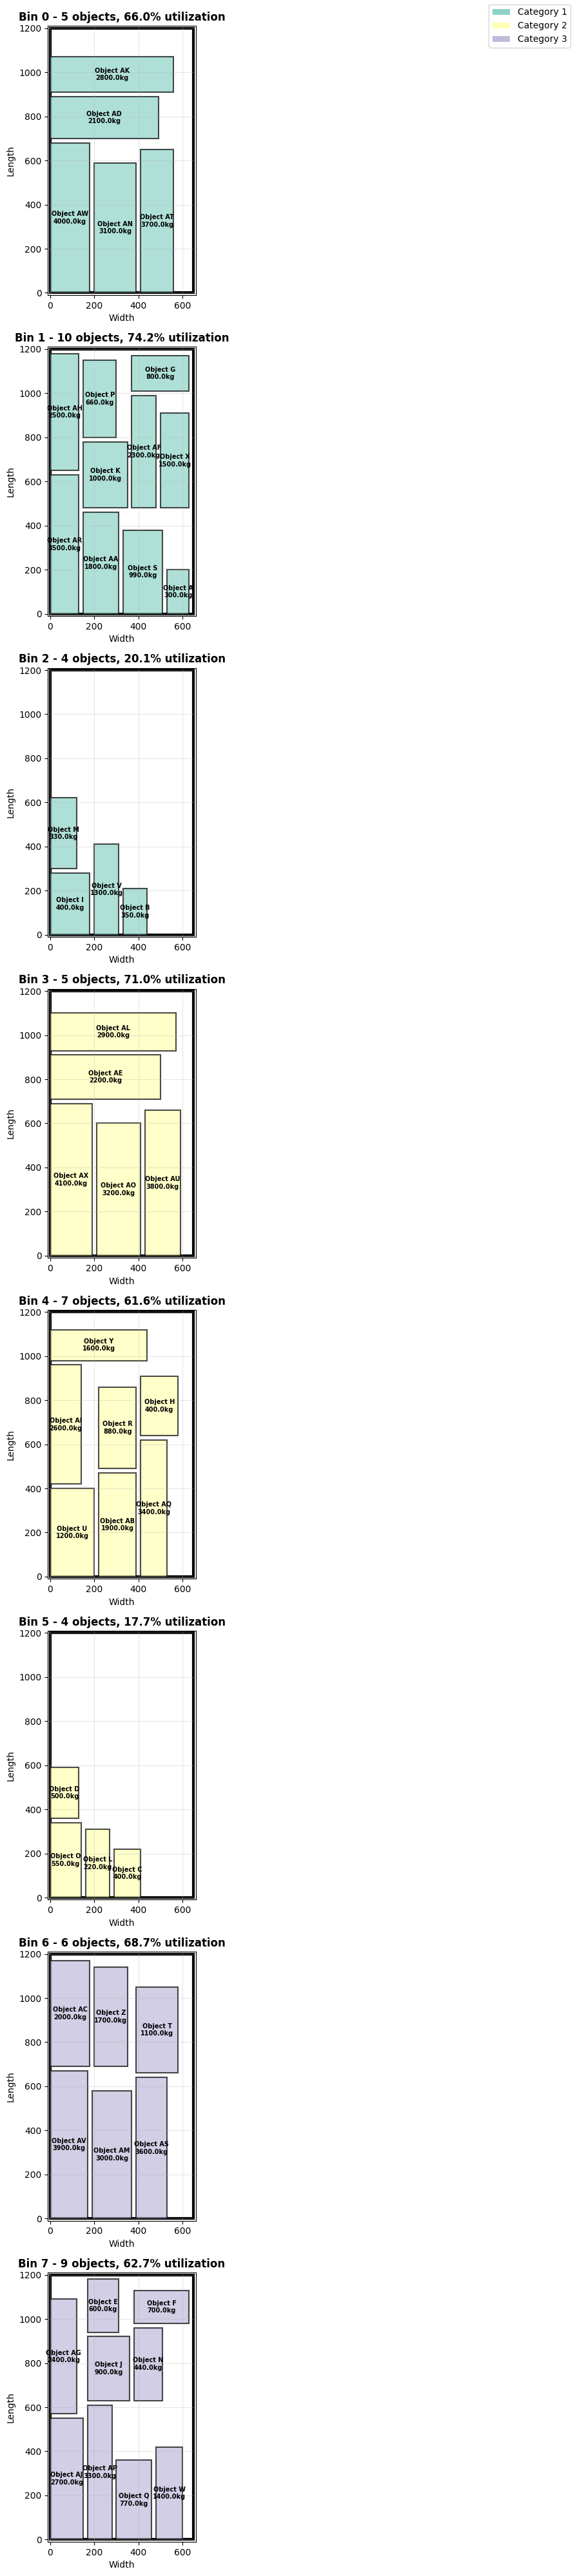

✓ Visualization complete


In [69]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Visualize bins
fig, axes = plt.subplots(len(bins), 1, figsize=(14, 5*len(bins)))

# Handle single bin case
if len(bins) == 1:
    axes = [axes]

# Color map for categories
categories = objects_df['category'].unique()
color_map = {cat: plt.cm.Set3(i) for i, cat in enumerate(categories)}

for bin_idx, bin_obj in enumerate(bins):
    ax = axes[bin_idx]
    
    # Draw bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_obj.width, bin_obj.length, 
                                  linewidth=3, edgecolor='black', facecolor='none')
    ax.add_patch(bin_rect)
    
    # Draw objects
    stack_offset = {}
    for rect in bin_obj.rectangles:
        # Calculate stack offset
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 2
        
        # Get color based on category
        color = color_map.get(rect.category, 'gray')
        
        # Draw rectangle with offset for stacked items
        x = rect.x + offset
        y = rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        obj_rect = patches.Rectangle((x, y), w, l, 
                                     linewidth=1.5, edgecolor='black', 
                                     facecolor=color, alpha=0.7)
        ax.add_patch(obj_rect)
        
        # Add label
        label = f"{rect.obj_name}\n{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\n(x{rect.stack_height})"
        
        ax.text(x + w/2, y + l/2, label, ha='center', va='center', 
               fontsize=7, fontweight='bold')
    
    # Customize axis
    ax.set_xlim(-10, bin_obj.width + 10)
    ax.set_ylim(-10, bin_obj.length + 10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Width', fontsize=10)
    ax.set_ylabel('Length', fontsize=10)
    
    # Calculate utilization
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    
    ax.set_title(f'Bin {bin_idx} - {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization', 
                fontsize=12, fontweight='bold')

# Add legend
legend_elements = [patches.Patch(facecolor=color_map[cat], label=cat) 
                  for cat in sorted(categories)]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print('✓ Visualization complete')

In [7]:
print("=== DEBUGGING PACKING ===")
print(f"\nObjects DataFrame shape: {objects_df.shape}")
print(f"Objects DataFrame columns: {objects_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(objects_df.head())

print(f"\nData types:")
print(objects_df.dtypes)

print(f"\nUnique categories: {objects_df['category'].unique()}")
print(f"Number of categories: {objects_df['category'].nunique()}")

# Check for NaN values
print(f"\nMissing values:")
print(objects_df.isnull().sum())

# Try packing with verbose output
print("\n=== ATTEMPTING PACK ===")
try:
    bins = pack_objects(objects_df, bin_width=100, bin_length=100)
    print(f"Packing successful! Created {len(bins)} bins")
    for i, bin_obj in enumerate(bins):
        print(f"  Bin {i}: {len(bin_obj.rectangles)} objects")
except Exception as e:
    print(f"Packing failed: {e}")
    import traceback
    traceback.print_exc()

=== DEBUGGING PACKING ===

Objects DataFrame shape: (50, 9)
Objects DataFrame columns: ['object_id', 'name', 'category', 'width', 'length', 'height', 'weight', 'stackable', 'max_stack_height']

First few rows:
   object_id      name    category  width  length  height  weight  stackable  \
0          1  Object A  Category 1    100     200     150     300       True   
1          2  Object B  Category 1    110     210     160     350       True   
2          3  Object C  Category 2    120     220     170     400      False   
3          4  Object D  Category 2    130     230     175     500       True   
4          5  Object E  Category 3    140     240     180     600      False   

   max_stack_height  
0                10  
1                 8  
2                 0  
3                12  
4                 0  

Data types:
object_id           int64
name                  str
category              str
width               int64
length              int64
height              int64
weight  

## 6. Generate DXF from Optimized Plan

In [52]:
from ezdxf.enums import TextEntityAlignment

doc = ezdxf.new()
msp = doc.modelspace()

y_offset = 0
for bin_idx, bin_obj in enumerate(bins):
    bin_x = 0
    bin_y = y_offset
    
    # Draw bin boundary
    msp.add_lwpolyline([
        (bin_x, bin_y), 
        (bin_x + bin_obj.width, bin_y), 
        (bin_x + bin_obj.width, bin_y + bin_obj.length), 
        (bin_x, bin_y + bin_obj.length), 
        (bin_x, bin_y)
    ], close=True)
    
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 0.5
        
        x = bin_x + rect.x + offset
        y = bin_y + rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        # Draw rectangle
        msp.add_lwpolyline([
            (x, y), 
            (x + w, y), 
            (x + w, y + l), 
            (x, y + l), 
            (x, y)
        ], close=True)
        
        # Add MTEXT with multi-line formatting
        label = f"{rect.obj_name}\\P{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\\P(Stack: {rect.stack_height}x)"
        
        mtext = msp.add_mtext(label, dxfattribs={'char_height': 2})
        mtext.set_location((x + w/2, y + l/2),None,5)
    
    y_offset += bin_obj.length + 5

# Save DXF
os.makedirs('../data', exist_ok=True)
doc.saveas('../data/optimized_laydown.dxf')

print('✓ DXF generated: data/optimized_laydown.dxf')

✓ DXF generated: data/optimized_laydown.dxf


## 7. Summary

In [70]:
print('=== OPTIMIZATION SUMMARY ===')
print(f'Total objects: {len(objects_df)}')
print(f'Total bins created: {len(bins)}')
print(f'\nBin Details:')
for i, bin_obj in enumerate(bins):
    stacked = sum(1 for rect in bin_obj.rectangles if rect.stack_height > 1)
    print(f'  Bin {i}: {len(bin_obj.rectangles)} items, {stacked} stacks')
print('✓ Optimization complete!')

=== OPTIMIZATION SUMMARY ===
Total objects: 50
Total bins created: 8

Bin Details:
  Bin 0: 5 items, 0 stacks
  Bin 1: 10 items, 0 stacks
  Bin 2: 4 items, 0 stacks
  Bin 3: 5 items, 0 stacks
  Bin 4: 7 items, 0 stacks
  Bin 5: 4 items, 0 stacks
  Bin 6: 6 items, 0 stacks
  Bin 7: 9 items, 0 stacks
✓ Optimization complete!


## 8. Genetic Algorithm

In [71]:
import random
import numpy as np
from copy import deepcopy

class GeneticAlgorithmPacker:
    """
    Genetic Algorithm for 2D bin packing optimization.
    Evolves solutions to find near-optimal packings.
    """
    
    def __init__(self, population_size=50, generations=20, mutation_rate=0.1, crossover_rate=0.8):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.best_solutions = []
    
    def pack_objects_ga(self, objects_df, bin_width=350, bin_length=1100, min_spacing=0, compatibility_matrix=None):
        """
        Use genetic algorithm to find optimal packing with segregation rules.
        """
        # Prepare objects
        categories = objects_df['category'].unique()
        all_rectangles = []
        
        for category in categories:
            category_df = objects_df[objects_df['category'] == category]
            for _, row in category_df.iterrows():
                rect = Rectangle(
                    width=float(row['width']),
                    length=float(row['length']),
                    obj_id=row['object_id'],
                    obj_name=row['name'],
                    category=row['category'],
                    weight=float(row['weight']),
                    stackable=row['stackable'] in [True, 'True', 'TRUE'],
                    max_stack=int(row['max_stack_height'])
                )
                all_rectangles.append(rect)
        
        print(f"\n=== GENETIC ALGORITHM PACKING ===")
        print(f"Population size: {self.population_size}")
        print(f"Generations: {self.generations}")
        print(f"Objects to pack: {len(all_rectangles)}")
        
        # Initialize population (random orderings)
        population = [random.sample(all_rectangles, len(all_rectangles)) 
                     for _ in range(self.population_size)]
        
        best_fitness = float('inf')
        best_solution = None
        
        for generation in range(self.generations):
            # Evaluate fitness for all solutions
            fitnesses = []
            solutions = []
            
            for solution in population:
                bins = self._pack_from_ordering(solution, bin_width, bin_length, min_spacing)
                fitness = self._calculate_fitness(bins)
                fitnesses.append(fitness)
                solutions.append((fitness, bins, solution))
            
            # Sort by fitness (lower is better)
            solutions.sort(key=lambda x: x[0])
            best_gen_fitness = solutions[0][0]
            
            if best_gen_fitness < best_fitness:
                best_fitness = best_gen_fitness
                best_solution = solutions[0]
                print(f"  Gen {generation + 1}: Fitness = {best_fitness:.2f} (Bins: {len(best_solution[1])})")
            else:
                print(f"  Gen {generation + 1}: Fitness = {best_gen_fitness:.2f} (Bins: {len(solutions[0][1])})")
            
            # Selection: keep top 20%
            elite_size = max(1, self.population_size // 5)
            elite = [solutions[i][2] for i in range(elite_size)]
            
            # Create new population
            new_population = elite[:]
            
            while len(new_population) < self.population_size:
                # Tournament selection
                parent1 = self._tournament_selection(solutions)
                parent2 = self._tournament_selection(solutions)
                
                # Crossover
                if random.random() < self.crossover_rate:
                    child1, child2 = self._crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)
                
                # Mutation
                if random.random() < self.mutation_rate:
                    child1 = self._mutate(child1)
                if random.random() < self.mutation_rate:
                    child2 = self._mutate(child2)
                
                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)
            
            population = new_population[:self.population_size]
        
        print(f"\n✓ GA Complete: {len(best_solution[1])} bins, Fitness: {best_fitness:.2f}")
        self.best_solutions.append((best_fitness, best_solution[1]))
        
        return best_solution[1]
    
    def _pack_from_ordering(self, ordering, bin_width, bin_length, min_spacing):
        """Pack objects using a specific ordering."""
        bins = []
        
        for rect in ordering:
            placed = False
            
            # Try existing bins
            for bin_obj in bins:
                positions = [(0, 0)]
                for existing in bin_obj.rectangles:
                    positions.append((existing.x + existing.get_width() + min_spacing, existing.y))
                    positions.append((existing.x, existing.y + existing.get_length() + min_spacing))
                
                for x, y in positions:
                    rect.x = x
                    rect.y = y
                    rect.rotated = False
                    
                    if (rect.x + rect.get_width() + min_spacing <= bin_obj.width and
                        rect.y + rect.get_length() + min_spacing <= bin_obj.length):
                        
                        overlaps = False
                        for existing in bin_obj.rectangles:
                            if bin_obj._overlaps(rect, existing):
                                overlaps = True
                                break
                        
                        if not overlaps:
                            bin_obj.rectangles.append(rect)
                            placed = True
                            break
                    
                    rect.rotated = True
                    if (rect.x + rect.get_width() + min_spacing <= bin_obj.width and
                        rect.y + rect.get_length() + min_spacing <= bin_obj.length):
                        
                        overlaps = False
                        for existing in bin_obj.rectangles:
                            if bin_obj._overlaps(rect, existing):
                                overlaps = True
                                break
                        
                        if not overlaps:
                            bin_obj.rectangles.append(rect)
                            placed = True
                            break
                    
                    rect.rotated = False
                
                if placed:
                    break
            
            # Create new bin if needed
            if not placed:
                new_bin = Bin(bin_width, bin_length, len(bins), min_spacing=min_spacing)
                rect.x = 0
                rect.y = 0
                rect.rotated = False
                new_bin.rectangles.append(deepcopy(rect))
                bins.append(new_bin)
        
        return bins
    
    def _calculate_fitness(self, bins):
        """
        Calculate fitness score (lower is better).
        Considers: number of bins, utilization, weight distribution
        """
        num_bins = len(bins)
        total_utilization = 0
        
        for bin_obj in bins:
            if len(bin_obj.rectangles) > 0:
                total_area = sum(rect.area() for rect in bin_obj.rectangles)
                bin_area = bin_obj.width * bin_obj.length
                utilization = total_area / bin_area
                total_utilization += utilization
        
        avg_utilization = total_utilization / len(bins) if bins else 0
        
        # Fitness = bins (primary) + (1 - utilization) (secondary)
        # Lower fitness is better
        fitness = num_bins + (1 - avg_utilization) * 0.5
        
        return fitness
    
    def _tournament_selection(self, solutions, tournament_size=3):
        """Select best solution from random tournament."""
        tournament = random.sample(solutions, min(tournament_size, len(solutions)))
        tournament.sort(key=lambda x: x[0])
        return deepcopy(tournament[0][2])
    
    def _crossover(self, parent1, parent2):
        """Order Crossover (OX) for permutations."""
        size = len(parent1)
        start = random.randint(0, size - 2)
        end = random.randint(start + 1, size - 1)
        
        child1 = parent1[:]
        child2 = parent2[:]
        
        # Copy segment
        segment1 = parent1[start:end]
        segment2 = parent2[start:end]
        
        # Fill rest with remaining elements in order
        def fill_child(child, segment, other_parent):
            used = set(segment)
            pos = end
            for item in other_parent[end:] + other_parent[:end]:
                if item not in used:
                    if pos >= len(child):
                        pos = 0
                    child[pos] = item
                    pos += 1
            return child
        
        child1[start:end] = segment2
        child2[start:end] = segment1
        
        return child1, child2
    
    def _mutate(self, solution):
        """Swap mutation: swap two random elements."""
        solution = deepcopy(solution)
        idx1, idx2 = random.sample(range(len(solution)), 2)
        solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
        return solution

print('✓ Genetic Algorithm Packer defined')

✓ Genetic Algorithm Packer defined


### 8.5 Execute Genetic Algorithm

In [72]:
# Use Genetic Algorithm for packing
use_ga = input("Use Genetic Algorithm for better packing? (y/n, default n): ").strip().lower()

if use_ga == 'y':
    ga_packer = GeneticAlgorithmPacker(
        population_size=50,      # Number of solutions per generation
        generations=20,          # Number of generations to evolve
        mutation_rate=0.1,       # 10% chance to mutate
        crossover_rate=0.8       # 80% chance to crossover
    )
    
    bins = ga_packer.pack_objects_ga(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing)
    print(f"\n✓ GA Packing complete: {len(bins)} bins")
else:
    # Use regular packing
    bins = pack_objects(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing)
    print(f"\n✓ Standard packing complete: {len(bins)} bins")

print(f'Total objects packed: {sum(len(bin.rectangles) for bin in bins)}')

for i, bin_obj in enumerate(bins):
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    print(f'Bin {i}: {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization')


=== GENETIC ALGORITHM PACKING ===
Population size: 50
Generations: 20
Objects to pack: 50
  Gen 1: Fitness = 7.18 (Bins: 7)
  Gen 2: Fitness = 6.17 (Bins: 6)
  Gen 3: Fitness = 6.16 (Bins: 6)
  Gen 4: Fitness = 6.16 (Bins: 6)
  Gen 5: Fitness = 6.16 (Bins: 6)
  Gen 6: Fitness = 6.16 (Bins: 6)
  Gen 7: Fitness = 6.15 (Bins: 6)
  Gen 8: Fitness = 6.15 (Bins: 6)
  Gen 9: Fitness = 6.15 (Bins: 6)
  Gen 10: Fitness = 6.15 (Bins: 6)
  Gen 11: Fitness = 6.15 (Bins: 6)
  Gen 12: Fitness = 6.15 (Bins: 6)
  Gen 13: Fitness = 6.15 (Bins: 6)
  Gen 14: Fitness = 6.15 (Bins: 6)
  Gen 15: Fitness = 6.15 (Bins: 6)
  Gen 16: Fitness = 6.15 (Bins: 6)
  Gen 17: Fitness = 6.15 (Bins: 6)
  Gen 18: Fitness = 6.15 (Bins: 6)
  Gen 19: Fitness = 6.15 (Bins: 6)
  Gen 20: Fitness = 6.14 (Bins: 6)

✓ GA Complete: 6 bins, Fitness: 6.14

✓ GA Packing complete: 6 bins
Total objects packed: 50
Bin 0: 11 objects, 76.0% utilization
Bin 1: 9 objects, 72.0% utilization
Bin 2: 8 objects, 77.7% utilization
Bin 3: 8 object

## 9. Compare

In [73]:
import matplotlib.pyplot as plt

# Run both algorithms and compare
print("=== COMPARING PACKING ALGORITHMS ===\n")

# Standard packing
print("1. Running STANDARD GREEDY packing...")
bins_standard = pack_objects(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing)

standard_metrics = {
    'num_bins': len(bins_standard),
    'total_objects': sum(len(bin.rectangles) for bin in bins_standard),
    'avg_utilization': np.mean([
        sum(rect.area() for rect in bin.rectangles) / (bin.width * bin.length) 
        for bin in bins_standard
    ]) * 100,
    'total_area_used': sum(sum(rect.area() for rect in bin.rectangles) for bin in bins_standard),
    'total_weight': sum(sum(rect.weight for rect in bin.rectangles) for bin in bins_standard)
}

print(f"  ✓ Standard: {standard_metrics['num_bins']} bins, {standard_metrics['avg_utilization']:.1f}% utilization\n")

# Genetic Algorithm packing
print("2. Running GENETIC ALGORITHM packing...")
ga_packer = GeneticAlgorithmPacker(population_size=50, generations=20, mutation_rate=0.1, crossover_rate=0.8)
bins_ga = ga_packer.pack_objects_ga(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing)

ga_metrics = {
    'num_bins': len(bins_ga),
    'total_objects': sum(len(bin.rectangles) for bin in bins_ga),
    'avg_utilization': np.mean([
        sum(rect.area() for rect in bin.rectangles) / (bin.width * bin.length) 
        for bin in bins_ga
    ]) * 100,
    'total_area_used': sum(sum(rect.area() for rect in bin.rectangles) for bin in bins_ga),
    'total_weight': sum(sum(rect.weight for rect in bin.rectangles) for bin in bins_ga)
}

print(f"  ✓ GA: {ga_metrics['num_bins']} bins, {ga_metrics['avg_utilization']:.1f}% utilization\n")

# Calculate improvements
improvement_bins = ((standard_metrics['num_bins'] - ga_metrics['num_bins']) / standard_metrics['num_bins']) * 100
improvement_util = ga_metrics['avg_utilization'] - standard_metrics['avg_utilization']

print("=" * 60)
print("COMPARISON RESULTS")
print("=" * 60)
print(f"\n{'Metric':<30} {'Standard':<15} {'Genetic Algo':<15}")
print("-" * 60)
print(f"{'Number of Bins':<30} {standard_metrics['num_bins']:<15} {ga_metrics['num_bins']:<15}")
print(f"{'Objects Packed':<30} {standard_metrics['total_objects']:<15} {ga_metrics['total_objects']:<15}")
print(f"{'Avg Utilization':<30} {standard_metrics['avg_utilization']:.1f}%{'':<10} {ga_metrics['avg_utilization']:.1f}%")
print(f"{'Total Weight (kg)':<30} {standard_metrics['total_weight']:<15.0f} {ga_metrics['total_weight']:<15.0f}")
print("-" * 60)
print(f"\n{'IMPROVEMENTS':<30}")
print(f"  • Bins reduced: {improvement_bins:.1f}%")
print(f"  • Utilization improved: {improvement_util:.1f}%")
if improvement_bins > 0:
    print(f"  • Cost savings: ~{improvement_bins:.1f}% fewer bins needed! 🎉")
else:
    print(f"  • Both algorithms found equivalent solutions")

print("\n" + "=" * 60)

# Store for visualization
bins_comparison = {
    'Standard': bins_standard,
    'Genetic Algorithm': bins_ga,
    'Standard Metrics': standard_metrics,
    'GA Metrics': ga_metrics
}

=== COMPARING PACKING ALGORITHMS ===

1. Running STANDARD GREEDY packing...

Processing category: Category 1 (19 objects)
    New bin: Object AW (normal)
    Placed: Object AN at (200.0, 0)
    Placed: Object AT at (410.0, 0)
    Placed (rotated): Object AD at (0, 700.0)
    Placed (rotated): Object AK at (0, 910.0)
    New bin: Object AR (normal)
    Placed: Object AA at (150.0, 0)
    Placed: Object AH at (0, 650.0)
    Placed: Object S at (330.0, 0)
    Placed: Object K at (150.0, 480.0)
    Placed: Object AF at (370.0, 480.0)
    Placed: Object X at (500.0, 480.0)
    Placed: Object P at (150.0, 800.0)
    New bin: Object I (normal)
    Placed: Object V at (200.0, 0)
    Placed (rotated): Object G at (370.0, 1010.0)
    Placed: Object M at (0, 300.0)
    Placed: Object B at (330.0, 0)
    Placed: Object A at (530.0, 0)
  ✓ Created 3 bins for category Category 1

Processing category: Category 2 (16 objects)
    New bin: Object AX (normal)
    Placed: Object AO at (210.0, 0)
    Plac

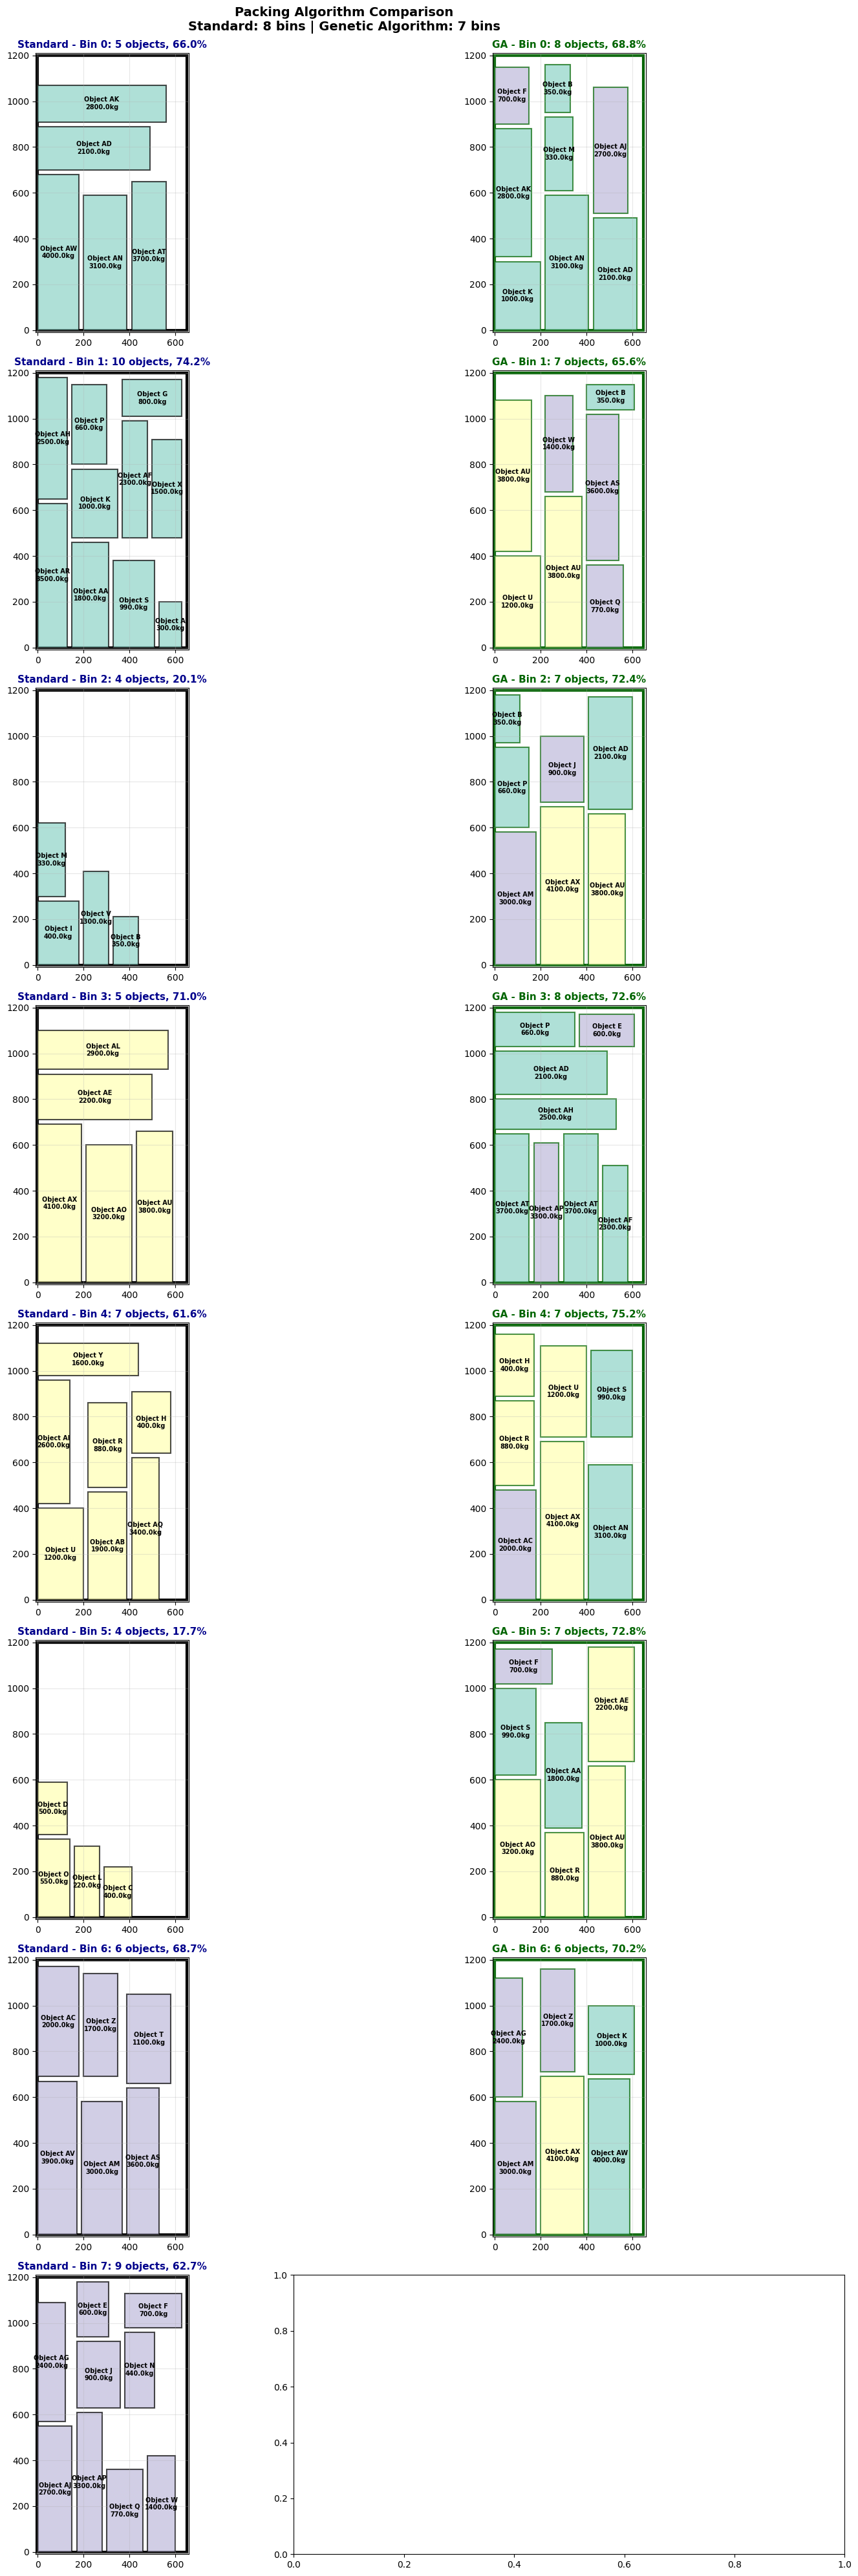

✓ Comparison visualization complete


In [74]:
# Visualize comparison
fig, axes = plt.subplots(
    max(len(bins_standard), len(bins_ga)), 
    2, 
    figsize=(16, 5 * max(len(bins_standard), len(bins_ga)))
)

if max(len(bins_standard), len(bins_ga)) == 1:
    axes = axes.reshape(1, -1)

categories = objects_df['category'].unique()
color_map = {cat: plt.cm.Set3(i) for i, cat in enumerate(categories)}

# Standard Packing
for bin_idx, bin_obj in enumerate(bins_standard):
    ax = axes[bin_idx, 0]
    
    # Draw bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_obj.width, bin_obj.length, 
                                  linewidth=3, edgecolor='black', facecolor='none')
    ax.add_patch(bin_rect)
    
    # Draw objects
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 2
        
        color = color_map.get(rect.category, 'gray')
        x = rect.x + offset
        y = rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        obj_rect = patches.Rectangle((x, y), w, l, 
                                     linewidth=1.5, edgecolor='black', 
                                     facecolor=color, alpha=0.7)
        ax.add_patch(obj_rect)
        
        label = f"{rect.obj_name}\n{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\n(x{rect.stack_height})"
        
        ax.text(x + w/2, y + l/2, label, ha='center', va='center', 
               fontsize=7, fontweight='bold')
    
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    
    ax.set_xlim(-10, bin_obj.width + 10)
    ax.set_ylim(-10, bin_obj.length + 10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Standard - Bin {bin_idx}: {len(bin_obj.rectangles)} objects, {utilization:.1f}%', 
                fontsize=11, fontweight='bold', color='darkblue')

# GA Packing
for bin_idx, bin_obj in enumerate(bins_ga):
    ax = axes[bin_idx, 1]
    
    # Draw bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_obj.width, bin_obj.length, 
                                  linewidth=3, edgecolor='darkgreen', facecolor='none')
    ax.add_patch(bin_rect)
    
    # Draw objects
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 2
        
        color = color_map.get(rect.category, 'gray')
        x = rect.x + offset
        y = rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        obj_rect = patches.Rectangle((x, y), w, l, 
                                     linewidth=1.5, edgecolor='darkgreen', 
                                     facecolor=color, alpha=0.7)
        ax.add_patch(obj_rect)
        
        label = f"{rect.obj_name}\n{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\n(x{rect.stack_height})"
        
        ax.text(x + w/2, y + l/2, label, ha='center', va='center', 
               fontsize=7, fontweight='bold')
    
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    
    ax.set_xlim(-10, bin_obj.width + 10)
    ax.set_ylim(-10, bin_obj.length + 10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'GA - Bin {bin_idx}: {len(bin_obj.rectangles)} objects, {utilization:.1f}%', 
                fontsize=11, fontweight='bold', color='darkgreen')

# Hide extra subplots
for idx in range(max(len(bins_standard), len(bins_ga)), len(axes)):
    axes[idx, 0].axis('off')
    axes[idx, 1].axis('off')

plt.suptitle(f'Packing Algorithm Comparison\nStandard: {len(bins_standard)} bins | Genetic Algorithm: {len(bins_ga)} bins', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print('✓ Comparison visualization complete')

### 9.5 Metrics Chart

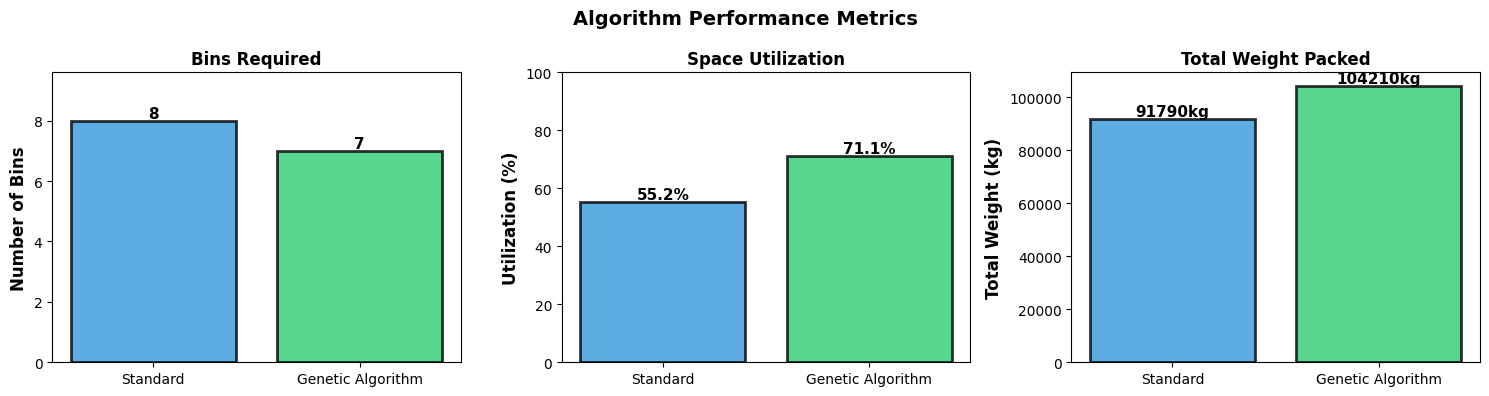

✓ Metrics charts complete


In [75]:
# Create comparison charts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Chart 1: Number of Bins
algorithms = ['Standard', 'Genetic Algorithm']
bins_count = [standard_metrics['num_bins'], ga_metrics['num_bins']]
colors = ['#3498db', '#2ecc71']

bars1 = axes[0].bar(algorithms, bins_count, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Bins', fontsize=12, fontweight='bold')
axes[0].set_title('Bins Required', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(bins_count) * 1.2)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Chart 2: Utilization
utilization = [standard_metrics['avg_utilization'], ga_metrics['avg_utilization']]
bars2 = axes[1].bar(algorithms, utilization, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Utilization (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Space Utilization', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 100)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Chart 3: Total Weight Distribution
weights = [standard_metrics['total_weight'], ga_metrics['total_weight']]
bars3 = axes[2].bar(algorithms, weights, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Total Weight (kg)', fontsize=12, fontweight='bold')
axes[2].set_title('Total Weight Packed', fontsize=12, fontweight='bold')
for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}kg',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('Algorithm Performance Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('✓ Metrics charts complete')